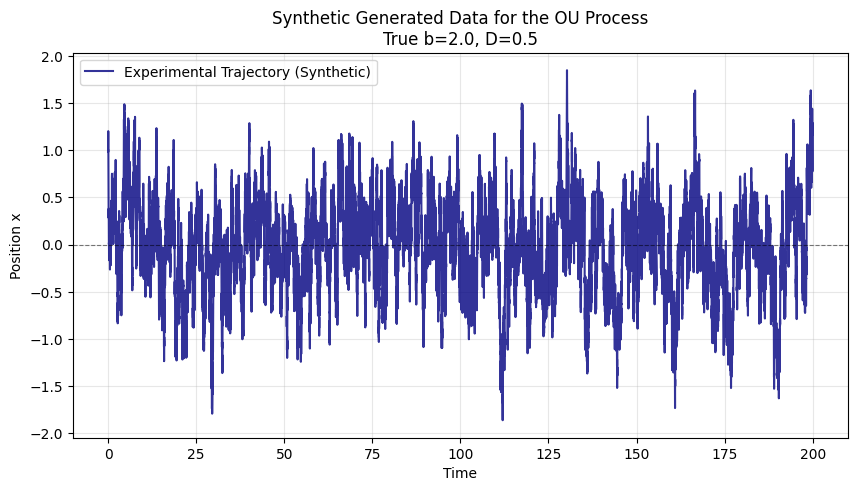

Data generated with 40000 points.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_ou_process(b_true, D, x0, T, dt, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    N = int(T / dt)  # Number of steps
    time = np.linspace(0, T, N)
    x = np.zeros(N)
    x[0] = x0
    
    # Pre-generating random noise terms (Gaussian N(0,1))
    noise = np.random.normal(0, 1, N)
    
    # Euler method Integration
    # x(t+1) = x(t) + drift * dt + diffusion * sqrt(dt) * noise
    for i in range(1, N):
        drift = -b_true * x[i-1] * dt
        diffusion = np.sqrt(2 * D * dt) * noise[i]
        x[i] = x[i-1] + drift + diffusion
        
    return time, x

# Configuration
# True physics parameters (We will try to recover 'b_true' later)
B_TRUE = 2.0      # The parameter to estimate
D_COEFF = 0.5     # Noise strength (assumed known)
X0 = 1.0          # Start away from center to see decay
TOTAL_TIME = 200.0
DT = 0.005

# Running the Simulation
time_data, position_data = simulate_ou_process(B_TRUE, D_COEFF, X0, TOTAL_TIME, DT, seed=42)

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(time_data, position_data, label='Experimental Trajectory (Synthetic)', color='navy', alpha=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.title(f"Synthetic Generated Data for the OU Process\nTrue b={B_TRUE}, D={D_COEFF}")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

# We only really need the position array and the time step for inference
print(f"Data generated with {len(position_data)} points.")

In [2]:
import numpy as np

class TruncatedSeries:
    def __init__(self, coeffs, max_order=None):
        # Handles single numbers (int/float/numpy scalars)
        if np.isscalar(coeffs):
            self.coeffs = np.array([coeffs], dtype=float)
        else:
            self.coeffs = np.array(coeffs, dtype=float)
            
        self.max_order = len(self.coeffs) - 1 if max_order is None else max_order
        
        # Pads with zeros if necessary
        if len(self.coeffs) < self.max_order + 1:
            pad_width = (self.max_order + 1) - len(self.coeffs)
            self.coeffs = np.pad(self.coeffs, (0, pad_width), 'constant')

    def __repr__(self):
        terms = [f"{c:.4e}d^{i}" for i, c in enumerate(self.coeffs)]
        return " + ".join(terms)
    
    # The Missing Methods
    def __neg__(self):
        return TruncatedSeries(-self.coeffs, self.max_order)
    
    def __pos__(self):
        return self

    def __add__(self, other):
        other = self._ensure_type(other)
        new_coeffs = self.coeffs + other.coeffs
        return TruncatedSeries(new_coeffs, self.max_order)

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        other = self._ensure_type(other)
        new_coeffs = self.coeffs - other.coeffs
        return TruncatedSeries(new_coeffs, self.max_order)

    def __rsub__(self, other):
        other = self._ensure_type(other)
        new_coeffs = other.coeffs - self.coeffs
        return TruncatedSeries(new_coeffs, self.max_order)

    def __mul__(self, other):
        other = self._ensure_type(other)
        new_coeffs = np.zeros(self.max_order + 1)
        for i in range(self.max_order + 1):
            for j in range(i + 1):
                new_coeffs[i] += self.coeffs[j] * other.coeffs[i-j]
        return TruncatedSeries(new_coeffs, self.max_order)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(self, other):
        other = self._ensure_type(other)
        new_coeffs = np.zeros(self.max_order + 1)
        for i in range(self.max_order + 1):
            numerator = self.coeffs[i]
            for j in range(i):
                numerator -= new_coeffs[j] * other.coeffs[i-j]
            new_coeffs[i] = numerator / other.coeffs[0]
        return TruncatedSeries(new_coeffs, self.max_order)

    def __rtruediv__(self, other):
        other = self._ensure_type(other)
        return other.__truediv__(self)
    
    def _ensure_type(self, other):
        if isinstance(other, TruncatedSeries):
            return other
        # This handles floats, ints, and numpy scalars
        return TruncatedSeries(other, self.max_order)

In [3]:
def get_langevin_force(b_val, x_data, dt, D, mu_prior, sigma_prior):
    
    dx = x_data[1:] - x_data[:-1]
    x_t = x_data[:-1]
    
    sum_dx_x = np.sum(dx * x_t)      
    sum_xx_dt = np.sum(x_t**2 * dt) 
    
    # Computing the gradient using TruncatedSeries algebra
    likelihood_numerator = sum_dx_x + b_val * sum_xx_dt
    likelihood_grad = likelihood_numerator / (2 * D)
    
    # Prior Gradient
    # Gradient = (b - mu) / sigma^2
    prior_grad = (b_val - mu_prior) / (sigma_prior * sigma_prior)
    
    # Total Force
    force = -(likelihood_grad + prior_grad)
    
    return force

In [4]:
# Test Setup (To ensure that TruncatedSeries algebra is workinhg correctly)
sigma_test = TruncatedSeries([0.5, 1.0], max_order=1)
b_test = TruncatedSeries([2.0, 0.0], max_order=1) 
dummy_x = np.array([1.0, 0.9, 0.8])

f = get_langevin_force(b_test, dummy_x, dt=0.01, D=0.5, mu_prior=0.0, sigma_prior=sigma_test)

#This is to validate the TruncatedSeriers implementation
print("Validation")
print(f"Sigma Input: {sigma_test}")
print(f"Force Output: {f}")

Validation
Sigma Input: 5.0000e-01d^0 + 1.0000e+00d^1
Force Output: -7.8462e+00d^0 + 3.2000e+01d^1


In [5]:
def run_nspt_simulation(x_data, dt_data, dt_sim, n_steps, b_init, sigma_center, sigma_perturbation):
    
    # Initializing the variables
    b_series = TruncatedSeries([b_init, 0.0], max_order=1)
    sigma_series = TruncatedSeries([sigma_center, sigma_perturbation], max_order=1)
    
    b0_history = np.zeros(n_steps)
    b1_history = np.zeros(n_steps)
    
    diffusion_term = np.sqrt(2 * dt_sim) 
    
    print(f"Starting NSPT Simulation with Data DT={dt_data} and Sim DT={dt_sim}...")
    
    for i in range(n_steps):
        noise = np.random.normal(0, 1)
        
        # Calculating Force 
        force = get_langevin_force(b_series, x_data, dt_data, D=0.5, 
                                   mu_prior=2.0, 
                                   sigma_prior=sigma_series)
        
        # Updatinng the 0-th Order (Standard Langevin)
        b_series.coeffs[0] += force.coeffs[0] * dt_sim + noise * diffusion_term
        
        # Updating the 1st Order (Deterministic equation)
        b_series.coeffs[1] += force.coeffs[1] * dt_sim
        
        b0_history[i] = b_series.coeffs[0]
        b1_history[i] = b_series.coeffs[1]
        
    return b0_history, b1_history

In [6]:
# Run Configurations
DT_DATA = 0.005   

DT_SIM = 0.0001 
N_STEPS = 50000

SIGMA_STAR = 0.5
B_GUESS = 1.5

b0_trace, b1_trace = run_nspt_simulation(position_data, DT_DATA, DT_SIM, N_STEPS, B_GUESS, SIGMA_STAR, 1.0)

Starting NSPT Simulation with Data DT=0.005 and Sim DT=0.0001...


NSPT Results
Estimated b: 1.9965
True b: 2.0
Sensitivity: -0.0010


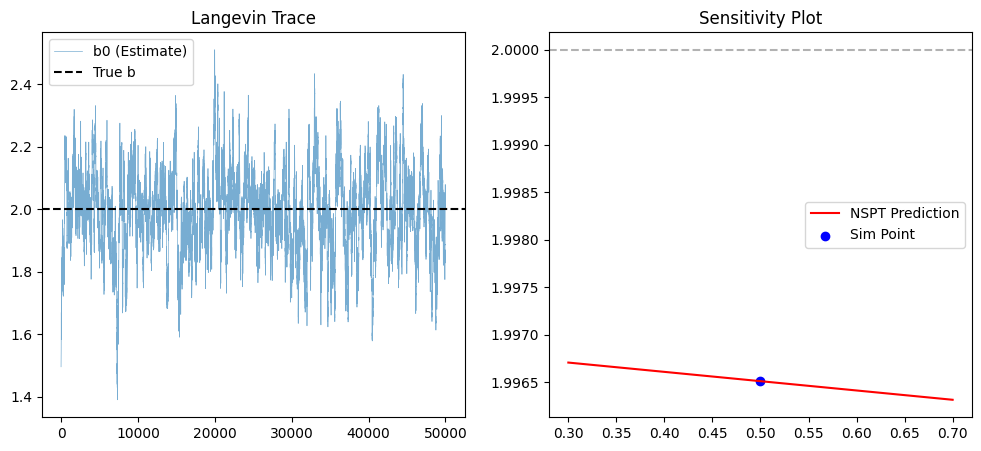

In [7]:
# Plotting the results
import matplotlib.pyplot as plt

burn_in = int(0.2 * N_STEPS)
b_estimate = np.mean(b0_trace[burn_in:])
b_sensitivity = np.mean(b1_trace[burn_in:])

print(f"NSPT Results")
print(f"Estimated b: {b_estimate:.4f}")
print(f"True b: {B_TRUE}")
print(f"Sensitivity: {b_sensitivity:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(b0_trace, label='b0 (Estimate)', alpha=0.6, linewidth=0.5)
plt.axhline(2.0, color='k', linestyle='--', label='True b')
plt.title("Langevin Trace")
plt.legend()

plt.subplot(1, 2, 2)
sigma_range = np.linspace(0.3, 0.7, 20)
predicted_b = b_estimate + b_sensitivity * (sigma_range - SIGMA_STAR)
plt.plot(sigma_range, predicted_b, color='red', label='NSPT Prediction')
plt.scatter([SIGMA_STAR], [b_estimate], color='blue', label='Sim Point')
plt.axhline(2.0, color='k', linestyle='--', alpha=0.3)
plt.title("Sensitivity Plot")
plt.legend()
plt.show()